In [3]:
!GIT_SSL_NO_VERIFY=1  pip install git+https://github.com/TimeSynth/TimeSynth.git

  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-8ujpoq6l
  Running command git clone --filter=blob:none --quiet https://github.com/TimeSynth/TimeSynth.git /tmp/pip-req-build-8ujpoq6l
  Resolved https://github.com/TimeSynth/TimeSynth.git to commit e50cdb9015d415adf46a4eae161a087c5c378564
  Preparing metadata (setup.py) ... done
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 24.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 20.2 MB/s eta 0:00:00
  DEPRECATION: Building 'timesynth' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by se

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import timesynth as ts
from timesynth.noise.gaussian_noise import GaussianNoise
from timesynth.signals import AutoRegressive, PseudoPeriodic, Sinusoidal
from timesynth import TimeSampler, TimeSeries
from typing import Any, Dict, List

In [112]:
def generate_timeseries(n_samples=300, frequency=0.25, amplitude=1.0, noise=GaussianNoise(std=0.3), cycles=1, signal=None):
    if not signal:
        signal = Sinusoidal(frequency=frequency)
        signal.amplitude = amplitude

    if cycles > 1:
        stop_time = cycles / frequency
    else:
        stop_time = n_samples / frequency
        
    time_sampler = TimeSampler(stop_time=stop_time)
    regular_time_samples = time_sampler.sample_regular_time(num_points=n_samples)

    timeseries = TimeSeries(signal_generator=signal, noise_generator=noise)
    samples, signals, errors = timeseries.sample(regular_time_samples)

    return regular_time_samples, samples, signals, errors

In [113]:
class CustomAutoRegressive(AutoRegressive):
    def sample_next(self, time, samples, errors):
        ar_value = sum(self.previous_value[i] * self.ar_param[i] for i in range(len(self.ar_param)))
        noise = float(np.random.normal(loc=0.0, scale=self.sigma))  # ensure scalar
        ar_value += noise
        self.previous_value = self.previous_value[1:] + [ar_value]
        
        return ar_value

In [163]:
def plot_timeseries(times_series: List[Dict[str, Any]], plot_errors=False, title='Generated Time Series Data') -> None:
    plt.figure(figsize=(10, 6))

    for i, series in enumerate(times_series):
        label = series['label'] if 'label' in series else 'Signal {i+1}'
        samples = np.array(series['samples'], dtype=float)
        signals = np.array(series['signals'], dtype=float)
        errors = series.get('errors', None)

        if isinstance(errors, str):
            print(f"Skipping 'errors' for Signal {i+1} because it is a string: {errors}")
            errors = None
        elif errors is not None:
            try:
                errors = np.array(errors, dtype=float)
            except Exception as e:
                print(f"Could not convert 'errors' for Signal {i+1}: {e}")
                errors = None

        plt.plot(samples, signals, label=label)
        
        if plot_errors and errors is not None:
            plt.plot(samples, signals + errors, label=f'Signal {i+1} with Noise', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [150]:
noise = GaussianNoise(std=0.1)
regular_time_samples_1, samples_1, signals_1, errors_1 = generate_timeseries(n_samples=100, amplitude=1.5, frequency=2, noise=noise, cycles=4)
regular_time_samples_2, samples_2, signals_2, errors_2 = generate_timeseries(n_samples=100, amplitude=1, frequency=2, noise=noise, cycles=4)
regular_time_samples_3, samples_3, signals_3, errors_3 = generate_timeseries(n_samples=100, amplitude=1.5, frequency=1, noise=noise)
regular_time_samples_4, samples_4, signals_4, errors_4 = generate_timeseries(n_samples=100, amplitude=1, frequency=1, noise=noise)

In [151]:
times_series_1 = {"samples" : regular_time_samples_1, "signals": signals_1, "errors": errors_1}
times_series_2 = {"samples" : regular_time_samples_2, "signals": signals_2, "errors": errors_2}
times_series = [times_series_1, times_series_2]

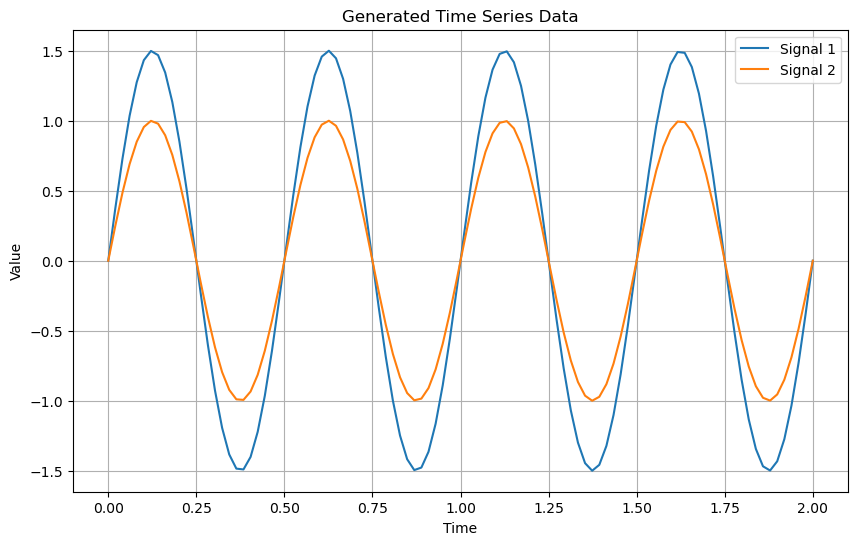

In [152]:
plot_timeseries(times_series)

In [153]:
times_series = [times_series_3, times_series_4]

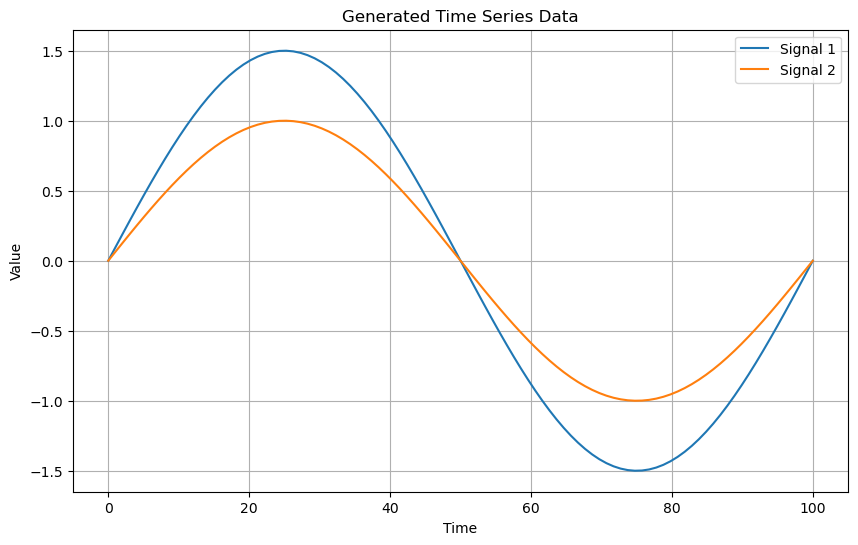

In [154]:
plot_timeseries(times_series)

In [120]:
signal = PseudoPeriodic(amplitude=1, frequency=0.25)
noise = GaussianNoise(std=0.3)

In [138]:
regular_time_samples, pseudo_periodic_samples, _, _ = \
    generate_timeseries(n_samples=100, 
    amplitude=1, 
    frequency=2, 
    noise=noise, 
    signal=signal)

In [139]:
signal = CustomAutoRegressive(ar_param=[0.90, -0.2])

In [140]:
regular_time_samples, ar_samples, _, _ = \
    generate_timeseries(n_samples=100, 
    amplitude=1, 
    frequency=2,                     
    signal=signal)

In [141]:
pad_length = len(pseudo_periodic_samples) - len(ar_samples)
ar_samples_padded = np.pad(ar_samples, (0, pad_length), mode='constant')
pseudo_periodic_with_ar_signal = pseudo_periodic_samples * 2 + ar_samples_padded

In [157]:
pseudo_periodic_with_ar_time_series = [{"samples" : regular_time_samples, 
                                        "signals": pseudo_periodic_with_ar_signal,
                                        "label": "AR Pseudoperiodic"},
                                       {"samples": regular_time_samples, 
                                        "signals": pseudo_periodic_samples,
                                        "label": "Pseudoperiodic"}]

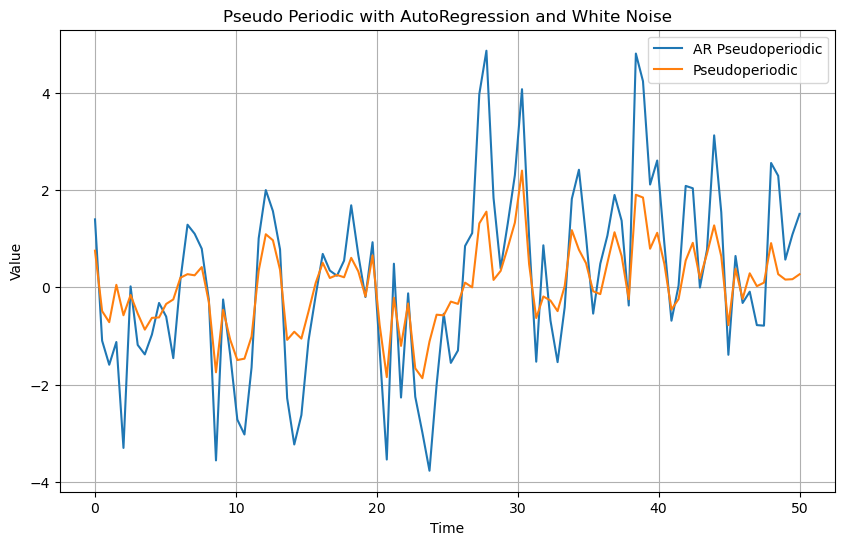

In [164]:
plot_timeseries(pseudo_periodic_with_ar_time_series, title="Pseudo Periodic with AutoRegression and White Noise")